# Residual Gallery - AF Lep b

## 1. Imports

In [1]:
from pathlib import Path
import pickle
import numpy as np
from scipy.ndimage import gaussian_filter

# Plotting
import cmocean
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
color_map = cmocean.cm.ice

# Methods
from fours.models.psf_subtraction import FourS
from fours.utils.pca import pca_psf_subtraction_gpu
from fours.utils.data_handling import read_fours_root_dir

# Evaluation
from applefy.utils.file_handling import load_adi_data

In [2]:
from bokeh.plotting import figure, show,  output_file, save
from bokeh.models import ColumnDataSource, CustomJS, Select, Label, Div, Legend, Span
from bokeh.layouts import column, row
from bokeh.models import ColorBar, LinearColorMapper, LogColorMapper
from bokeh.models import Slider, RangeSlider

from bokeh.core.validation import silence
from bokeh.core.validation.warnings import MISSING_RENDERERS
_=silence(MISSING_RENDERERS, True)

In [75]:
# Start the bokeh for jupyter notebooks
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## 2. Load the data

In [4]:
root_dir = Path(read_fours_root_dir())

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


In [5]:
dataset_file = root_dir / Path("30_data/HD35850_294_088_C-0085_A_.hdf5")
experiment_root_dir = root_dir / Path("70_results/x3_galleries/")

In [6]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_selected",
    psf_template_tag="psf_selected",
    para_tag="header_object_selected/PARANG")

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)

In [7]:
binning = 5  # stack every 5 frames
angles_stacked = np.array([
    np.mean(i) 
    for i in np.array_split(angles, int(len(angles) / binning))])
science_stacked = np.array([
    np.mean(i, axis=0) 
    for i in np.array_split(science_data, int(len(angles) / binning))])

# crop the frames
science_stacked_cut = science_stacked[:, 25:-25, 25:-25]

## 3. Get the PCA results

In [8]:
num_components = np.arange(5, 105, 5)
num_components

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])

In [9]:
pca_residuals_median = pca_psf_subtraction_gpu(
    images=science_stacked_cut,
    angles=angles_stacked,
    pca_numbers=num_components,
    device=0,
    combine="median",
    verbose = True)

pca_residuals_mean = pca_psf_subtraction_gpu(
    images=science_stacked_cut,
    angles=angles_stacked,
    pca_numbers=num_components,
    device=0,
    combine="mean",
    verbose = True)

Compute PCA basis ...[DONE]
Compute PCA residuals ...[DONE]
Compute PCA basis ...[DONE]
Compute PCA residuals ...[DONE]


## 4. Get 4S residuals

In [10]:
work_dir = experiment_root_dir / Path("S4")
work_dir.mkdir(exist_ok=True, parents=True)

In [11]:
lambda_regs = [100000, 50000, 10000, 5000, 1000]
fwhm = 3.6

all_mean_residuals = []
all_median_residuals = []

for tmp_lambda_reg in lambda_regs:
    s4_model = FourS(
        science_cube=science_stacked_cut,
        adi_angles=angles_stacked,
        psf_template=psf_template_data,
        device=0,
        work_dir=work_dir,
        verbose=True,
        rotation_grid_subsample=1,
        noise_model_lambda=tmp_lambda_reg,
        psf_fwhm=fwhm,
        right_reason_mask_factor=1.5)

    s4_model.fit_noise_model(
        num_epochs=100,
        training_name="AF_Lep_" + str(tmp_lambda_reg),
        logging_interval=1)

    s4_mean_residual, s4_median_residual = s4_model.compute_residuals()
    
    all_mean_residuals.append(s4_mean_residual)
    all_median_residuals.append(s4_median_residual)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]


## 5. Interactive Plot

In [12]:
zoom = 10
filter_strength = 0.3
pca_start_comp = 40

all_residuals_pca = dict()

for i, tmp_components in enumerate(num_components):
    all_residuals_pca[str(tmp_components) + "_" + "mean"] = gaussian_filter(
        pca_residuals_mean[i, zoom:-zoom, zoom:-zoom], 
        sigma=(filter_strength, filter_strength),order=0)
    
for i, tmp_components in enumerate(num_components):
    all_residuals_pca[str(tmp_components) + "_" + "median"] = gaussian_filter(
        pca_residuals_median[i, zoom:-zoom, zoom:-zoom], 
        sigma=(filter_strength, filter_strength),order=0)
    
residual_selected_pca = {"residual" : [all_residuals_pca[str(pca_start_comp) + "_median"]]}

In [13]:
s4_start_comp = 50000

all_residuals_4s = dict()

for i, tmp_lambda_reg in enumerate(lambda_regs):
    all_residuals_4s[str(tmp_lambda_reg) + "_" + "mean"] = gaussian_filter(
        all_mean_residuals[i][zoom:-zoom, zoom:-zoom],
        sigma=(filter_strength, filter_strength),order=0)
    all_residuals_4s[str(tmp_lambda_reg) + "_" + "median"] = gaussian_filter(
        all_median_residuals[i][zoom:-zoom, zoom:-zoom], 
        sigma=(filter_strength, filter_strength),order=0)
    
residual_selected_4s = {"residual" : [all_residuals_4s[str(s4_start_comp) + "_median"]]}

In [14]:
residual_size=pca_residuals_mean.shape[0]
fig_size=350

In [76]:
# 1.) Setup all the data needed for the plot ------------------------------
source_all_residuals_pca = ColumnDataSource(data=all_residuals_pca)
source_selected_residual_pca = ColumnDataSource(data=residual_selected_pca)

source_all_residuals_4s = ColumnDataSource(data=all_residuals_4s)
source_selected_residual_4s = ColumnDataSource(data=residual_selected_4s)

# 2. Residual Plot PCA ----------------------------------------------------------
plot_residual_pca = figure(
    width=fig_size, height=fig_size, 
    toolbar_location='left',
    tools="pan,wheel_zoom,reset,save",
    active_scroll="wheel_zoom",
    title="AF Lep b (PCA)")

plot_residual_pca.x_range.range_padding = 0
plot_residual_pca.y_range.range_padding = 0
plot_residual_pca.xaxis.visible = False
plot_residual_pca.yaxis.visible = False
plot_residual_pca.title.text_font_size = '12pt'

min_c = np.min(pca_residuals_mean)
max_c = np.max(pca_residuals_mean)

color_mapper_pca = LinearColorMapper(
    palette="Blues256",
    low=-1, high=3.5)

image = plot_residual_pca.image(
    image="residual",
    color_mapper=color_mapper_pca,
    x=0, y=0, 
    dw=residual_size, 
    dh=residual_size,
    source=source_selected_residual_pca)

# 2. Residual Plot 4S ----------------------------------------------------------
plot_residual_4s = figure(
    width=fig_size, height=fig_size, 
    toolbar_location='right',
    tools="pan,wheel_zoom,reset,save",
    active_scroll="wheel_zoom",
    title="AF Lep b (4S)")

plot_residual_4s.x_range.range_padding = 0
plot_residual_4s.y_range.range_padding = 0
plot_residual_4s.xaxis.visible = False
plot_residual_4s.yaxis.visible = False
plot_residual_4s.title.text_font_size = '12pt'

color_mapper_4s = LinearColorMapper(
    palette="Blues256",
    low=-0.03, high=0.12)

image = plot_residual_4s.image(
    image="residual",
    color_mapper=color_mapper_4s,
    x=0, y=0, 
    dw=residual_size, 
    dh=residual_size,
    source=source_selected_residual_4s)

# 4.) Widgets PCA ------------------------------------------------------------
color_slider_pca = RangeSlider(
    width=fig_size,
    start=-5, end=5, step=.1, 
    value=(-1, 3.5), 
    title="color range")

color_slider_pca.js_link("value", color_mapper_pca, "low", attr_selector=0)
color_slider_pca.js_link("value", color_mapper_pca, "high", attr_selector=1)

# PCA components
components_slider = Slider(
    title="PCA components", 
    start=5,
    end=np.max(num_components),
    step=5,
    width=fig_size,
    value=pca_start_comp)

pca_combine_select = Select(
    title="Combine", 
    width=fig_size,
    value="median", 
    options=["mean", "median"])

# 4.) Widgets 4S ------------------------------------------------------------
color_slider_4s = RangeSlider(
    width=fig_size,
    start=-0.2, end=0.2, step=.005, 
    value=(-0.03, 0.12), 
    title="color range")

color_slider_4s.js_link("value", color_mapper_4s, "low", attr_selector=0)
color_slider_4s.js_link("value", color_mapper_4s, "high", attr_selector=1)

# 4S setup
s4_setup_select = Select(
    title="Lambda", 
    width=fig_size,
    value=str(s4_start_comp), 
    options=[str(i) for i in lambda_regs])

s4_combine_select = Select(
    title="Combine", 
    width=fig_size,
    value="median", 
    options=["mean", "median"])

# 5.) Interaction ------------------------------------------------------------
code_widget = """
    // 1.) Update the PCA residual
    const current_id = components.value + "_" + combine.value;
    source_selected_residual_pca.data = {"residual": [source_all_residuals_pca.data[current_id],]};
"""

callback_pca = CustomJS(
    args=dict(
        source_selected_residual_pca = source_selected_residual_pca,
        source_all_residuals_pca = source_all_residuals_pca,
        components = components_slider,
        combine=pca_combine_select,
    ),
    code=code_widget)

components_slider.js_on_change('value', callback_pca)
pca_combine_select.js_on_change('value', callback_pca)

# 4S
code_widget = """
    // 1.) Update the 4S residual
    const current_id = setup.value + "_" + combine.value;
    source_selected_residual_4s.data = {"residual": [source_all_residuals_4s.data[current_id],]};
"""

callback_4s = CustomJS(
    args=dict(
        source_selected_residual_4s = source_selected_residual_4s,
        source_all_residuals_4s = source_all_residuals_4s,
        setup = s4_setup_select,
        combine = s4_combine_select,
    ),
    code=code_widget)

s4_setup_select.js_on_change('value', callback_4s)
s4_combine_select.js_on_change('value', callback_4s)

# 6.) Create the Layout
part_1 = row(
    plot_residual_pca, 
    plot_residual_4s)

part_2 = row(
    color_slider_pca, 
    color_slider_4s)

part_3 = row(
    components_slider, 
    s4_setup_select)

part_4 = row(
    pca_combine_select, 
    s4_combine_select)

final_plot = column(
    part_1,
    part_2,
    part_3,
    part_4)

#output_file("../../_static/gallery_af_lep.html")
#save(final_plot)
show(final_plot)

## 6. Create a gallery with all residuals

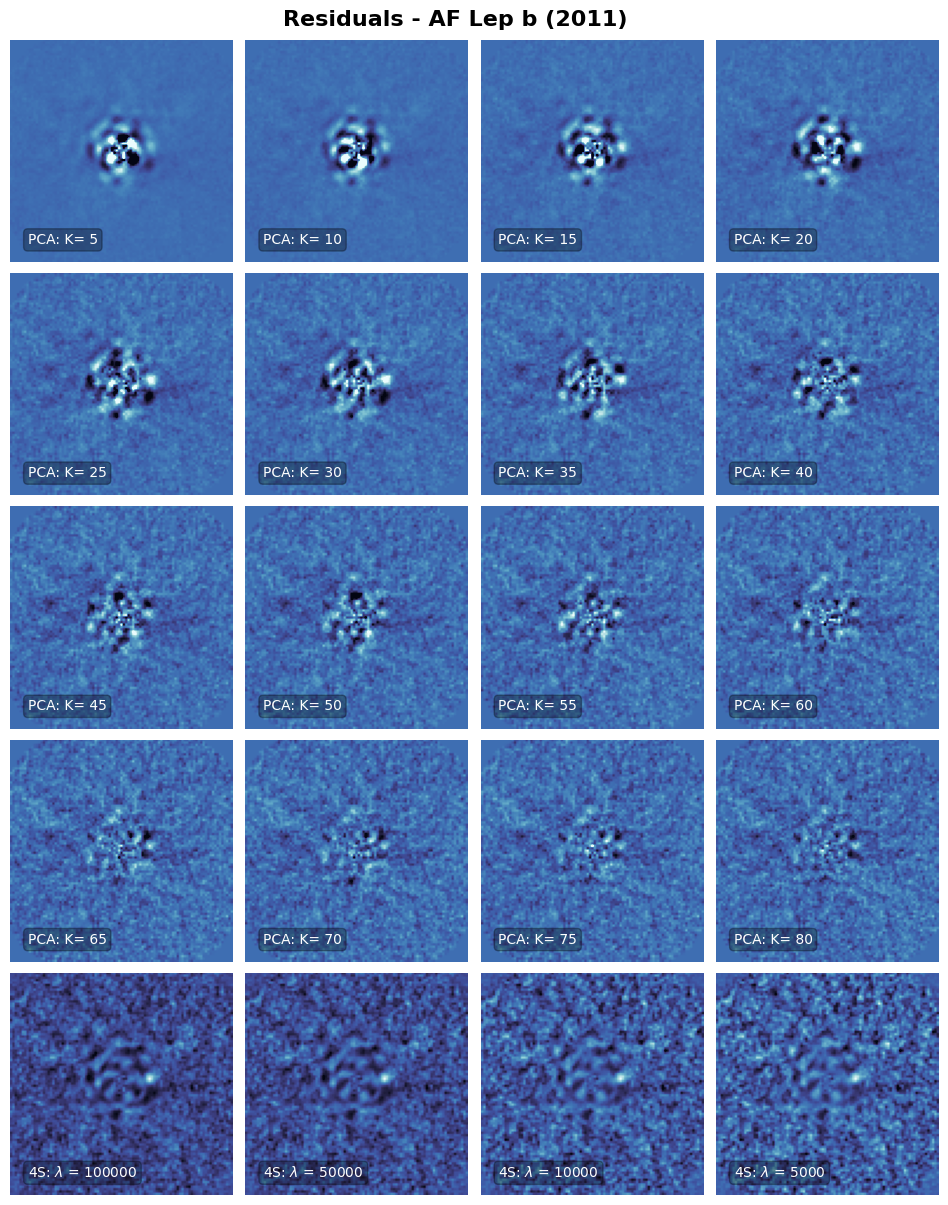

In [74]:
fig = plt.figure(constrained_layout=False, figsize=(12, 15))

gs01 = fig.add_gridspec(
    5, 4,
    wspace=0.05, hspace=0.05)

# Plot the PCA residuals
current_residual_idx = 0
for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(gs01[i, j])
        current_median = np.median(pca_residuals_median[current_residual_idx, zoom:-zoom, zoom:-zoom])
        current_std = np.std(pca_residuals_median[current_residual_idx, zoom:-zoom, zoom:-zoom])
        current_min = np.min(pca_residuals_median[current_residual_idx, zoom:-zoom, zoom:-zoom])
        current_max = np.max(pca_residuals_median[current_residual_idx, zoom:-zoom, zoom:-zoom])

        ax.imshow(
            gaussian_filter(pca_residuals_median[current_residual_idx, zoom:-zoom, zoom:-zoom],
                            sigma=(filter_strength, filter_strength),order=0),
            cmap=color_map,
            vmin=current_median - 5 * current_std,#current_min / 1.3,
            vmax=current_median + 6 * current_std
        )
        ax.axis("off")

        # add a text label with the number of components
        ax.text(
            0.08, 0.1,
            "PCA: K= " + str(num_components[current_residual_idx]),
            fontsize=10,
            color="white",
            # add bbox with round corners
            bbox=dict(facecolor='black',
                      boxstyle='round,pad=0.3',
                      alpha=0.3),
            ha='left', va='center',
            transform=ax.transAxes)

        current_residual_idx += 1

        #if i > 2:
        #    current_residual_idx += 1

# Plot the 4S residuals in the last row
current_residual_idx = 0

for i in range(4):
    ax = fig.add_subplot(gs01[4, i])
    current_median = np.median(all_mean_residuals[current_residual_idx][zoom:-zoom, zoom:-zoom])
    current_std = np.std(all_mean_residuals[current_residual_idx][zoom:-zoom, zoom:-zoom])
    current_min = np.min(all_mean_residuals[current_residual_idx][zoom:-zoom, zoom:-zoom])
    current_max = np.max(all_mean_residuals[current_residual_idx][zoom:-zoom, zoom:-zoom])

    ax.imshow(
        gaussian_filter(all_mean_residuals[current_residual_idx][zoom:-zoom, zoom:-zoom],
                        sigma=(filter_strength, filter_strength),order=0),
        cmap=color_map,
        vmin=-0.06,#current_min / 1.3,
        vmax=current_max
        )
    ax.axis("off")

    # add a text label with the number of components
    ax.text(
        0.08, 0.1,
        "4S: $\lambda$ = " + str(lambda_regs[current_residual_idx]),
        fontsize=10,
        color="white",
        # add bbox with round corners
        bbox=dict(facecolor='black',
                  boxstyle='round,pad=0.3',
                  alpha=0.3),
        ha='left', va='center',
        transform=ax.transAxes)

    current_residual_idx += 1
    
# add a figure title
fig.suptitle("Residuals - AF Lep b (2011) ", fontsize=16, y=0.9, fontweight='bold')

# Add Figure Title
fig.patch.set_facecolor('white')
plt.savefig("./final_plots/0a4_af_lep_gallery.pdf", bbox_inches='tight')